In [ ]:
import json
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import utils.config as config
from estimate import estimate
from compute_metrics import f1_score

In [ ]:
device = torch.device('cuda')
model = torch.load('logs/best_checkpoints/SWaT_parameters.pt', map_location=device)
model.eval()

In [17]:
# Load test dataset.
dataset = 'SWaT'  # or any dataset in SMAP/WSL/SMD/WADI
test_data = np.load(config.TEST_DATASET[dataset])
test_label = np.load(config.TEST_LABEL[dataset])

# Data divisions.
test_divisions = config.DEFAULT_DIVISION[dataset]
if test_divisions == 'total':
        test_divisions = [[0, len(test_data)]]
else:
    with open(config.DATA_DIVISION[dataset][test_divisions], 'r') as f:
        test_divisions = json.load(f)
    if isinstance(test_divisions, dict):
        test_divisions = test_divisions.values()

# Ignore the specific columns.
if dataset in config.IGNORED_COLUMNS.keys():
    ignored_column = np.array(config.IGNORED_COLUMNS[dataset])
    remaining_column = [col for col in range(len(test_data[0])) if col not in ignored_column]
    test_data = test_data[:, remaining_column]

In [18]:
# Estimate anomaly scores.
anomaly_scores = estimate(test_data, model, torch.nn.Sigmoid().to(device), 1, 64, 16, test_divisions, 5000, device)
anomaly_scores = anomaly_scores.cpu().numpy()

5056 windows are computed.
10048 windows are computed.
15040 windows are computed.
20032 windows are computed.
25024 windows are computed.


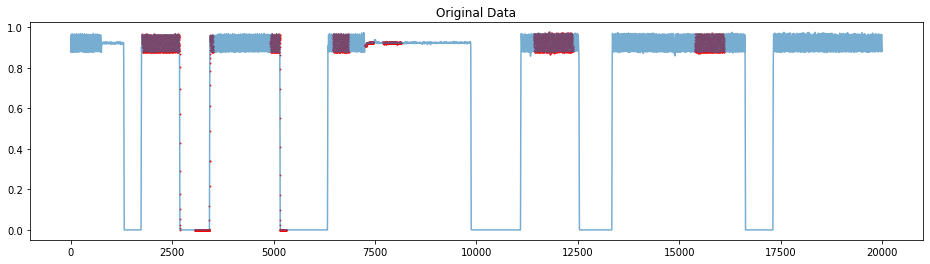

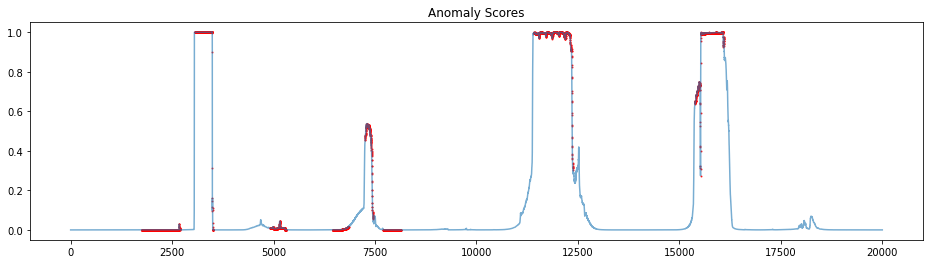

In [19]:
# Plot data and anomaly scores.
index = (0, 20000)  # interval for time steps
data_col_index = 0  # index of data column

label = test_label[index[0]:index[1]].astype(bool)

plt.figure(figsize=(16, 4))
plt.plot(test_data[index[0]:index[1], data_col_index], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], test_data[index[0]:index[1]][label, data_col_index],
            c='r', s=1, alpha=0.8)
plt.title('Original Data')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(anomaly_scores[index[0]:index[1], 0], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], anomaly_scores[index[0]:index[1]][label, 0],
            c='r', s=1, alpha=0.8)
plt.title('Anomaly Scores')
plt.show()

In [20]:
# Compute precisions, recalls, F1-scores of the result.
# Standard metrics
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, False)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score without point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

# Metrics after point adjustment
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, True)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score with point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

Best F1-score without point adjustment
anomaly rate: 0.097 | precision: 0.96132 | recall: 0.76863 | F1-score: 0.85425

Best F1-score with point adjustment
anomaly rate: 0.040 | precision: 0.97682 | recall: 0.87762 | F1-score: 0.92456

